# Binary Classification Model for Rain in Australia Using Python Take 1
### David Lowe
### March 26, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Rain in Australia dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: This dataset contains daily weather observations from numerous Australian weather stations. The target variable RainTomorrow represents whether it rained the next day. We also should exclude the variable Risk-MM when training a binary classification model. By not eliminating the Risk-MM feature, we run a risk of leaking the answers into our model and reduce its effectiveness.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average accuracy of 83.83%. Two algorithms (Extra Trees and Random Forest) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, Random Forest turned in a better overall result than Extra Trees with a lower variance. Random Forest achieved an accuracy metric of 85.44%. When configured with the optimized parameters, the Random Forest algorithm processed the test dataset with an accuracy of 85.52%, which was consistent with the accuracy score from the training phase.

CONCLUSION: For this iteration, the Random Forest algorithm achieved the best overall results using the training and test datasets. For this dataset, Random Forest should be considered for further modeling.

Dataset Used: Rain in Australia Data Set

Dataset ML Model: Binary classification with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

One potential source of performance benchmark: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package/kernels

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Environment

### 1.a) Load libraries and modules

In [1]:
# Set the random seed number for reproducible results
seedNum = 888

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import re
from datetime import datetime
from email.message import EmailMessage
from pandas.plotting import scatter_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

# Set various Pandas options
pd.set_option('display.max_rows', 9999)

In [4]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [5]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [6]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-rain-tomorrow-australia/weatherAUS.csv'

Xy_original = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_original.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,...,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,0.0,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,...,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,1.4,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,...,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,0.0,No


In [7]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [8]:
Xy_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [9]:
Xy_original.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [10]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  316559


### 1.d) Data Cleaning

In [11]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'RainTomorrow': 'targetVar'})

# Dropping features
Xy_original.drop(columns=['Date','RISK_MM'], inplace=True)

# Impute missing values
Xy_original['MinTemp'].fillna(value=Xy_original['MinTemp'].median(), inplace=True)
Xy_original['MaxTemp'].fillna(value=Xy_original['MaxTemp'].median(), inplace=True)
Xy_original['Rainfall'].fillna(0.0, inplace=True)
Xy_original['Evaporation'].fillna(0.0, inplace=True)
Xy_original['Sunshine'].fillna(value=Xy_original['Sunshine'].median(), inplace=True)
Xy_original['WindGustDir'].fillna("UNKNOWN", inplace=True)
Xy_original['WindGustSpeed'].fillna(0, inplace=True)
Xy_original['WindDir9am'].fillna("UNKNOWN", inplace=True)
Xy_original['WindDir3pm'].fillna("UNKNOWN", inplace=True)
Xy_original['WindSpeed9am'].fillna(0, inplace=True)
Xy_original['WindSpeed3pm'].fillna(0, inplace=True)
Xy_original['Humidity9am'].fillna(value=Xy_original['Humidity9am'].median(), inplace=True)
Xy_original['Humidity3pm'].fillna(value=Xy_original['Humidity3pm'].median(), inplace=True)
Xy_original['Pressure9am'].fillna(value=Xy_original['Pressure9am'].median(), inplace=True)
Xy_original['Pressure3pm'].fillna(value=Xy_original['Pressure3pm'].median(), inplace=True)
Xy_original['Cloud9am'].fillna(value=Xy_original['Cloud9am'].median(), inplace=True)
Xy_original['Cloud3pm'].fillna(value=Xy_original['Cloud3pm'].median(), inplace=True)
Xy_original['Temp9am'].fillna(value=Xy_original['Temp9am'].median(), inplace=True)
Xy_original['Temp3pm'].fillna(value=Xy_original['Temp3pm'].median(), inplace=True)
Xy_original['RainToday'].fillna("No", inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
Xy_original['Location'] = Xy_original['Location'].astype('category')
Xy_original['WindGustDir'] = Xy_original['WindGustDir'].astype('category')
Xy_original['WindDir9am'] = Xy_original['WindDir9am'].astype('category')
Xy_original['WindDir3pm'] = Xy_original['WindDir3pm'].astype('category')
Xy_original['RainToday'] = Xy_original['RainToday'].astype('category')

# Convert features with Yes/No levels into categorical feature of 1/0
def reClassRainTomorrow(target):
    if (target == 'Yes'): return 1
    else: return 0
Xy_original['targetVar'] = Xy_original['RainTomorrow'].apply(reClassRainTomorrow)
Xy_original.drop(columns=['RainTomorrow'], inplace=True)

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,targetVar
0,Albury,13.4,22.9,0.6,0.0,8.5,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,0
1,Albury,7.4,25.1,0.0,0.0,8.5,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No,0
2,Albury,12.9,25.7,0.0,0.0,8.5,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No,0
3,Albury,9.2,28.0,0.0,0.0,8.5,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No,0
4,Albury,17.5,32.3,1.0,0.0,8.5,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0
5,Albury,14.6,29.7,0.2,0.0,8.5,WNW,56.0,W,W,...,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,No,0
6,Albury,14.3,25.0,0.0,0.0,8.5,W,50.0,SW,W,...,49.0,19.0,1009.6,1008.2,1.0,5.0,18.1,24.6,No,0
7,Albury,7.7,26.7,0.0,0.0,8.5,W,35.0,SSE,W,...,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,No,0
8,Albury,9.7,31.9,0.0,0.0,8.5,NNW,80.0,SE,NW,...,42.0,9.0,1008.9,1003.6,5.0,5.0,18.3,30.2,No,1
9,Albury,13.1,30.1,1.4,0.0,8.5,W,28.0,S,SSE,...,58.0,27.0,1007.0,1005.7,5.0,5.0,20.1,28.2,Yes,0


In [12]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Location       142193 non-null  category
 1   MinTemp        142193 non-null  float64 
 2   MaxTemp        142193 non-null  float64 
 3   Rainfall       142193 non-null  float64 
 4   Evaporation    142193 non-null  float64 
 5   Sunshine       142193 non-null  float64 
 6   WindGustDir    142193 non-null  category
 7   WindGustSpeed  142193 non-null  float64 
 8   WindDir9am     142193 non-null  category
 9   WindDir3pm     142193 non-null  category
 10  WindSpeed9am   142193 non-null  float64 
 11  WindSpeed3pm   142193 non-null  float64 
 12  Humidity9am    142193 non-null  float64 
 13  Humidity3pm    142193 non-null  float64 
 14  Pressure9am    142193 non-null  float64 
 15  Pressure3pm    142193 non-null  float64 
 16  Cloud9am       142193 non-null  float64 
 17  Cloud3pm  

In [13]:
Xy_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,targetVar
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,12.185565,23.225365,2.326738,3.129340,8.042236,37.377592,13.869248,18.292855,68.858235,51.495742,1017.648460,1015.252481,4.649568,4.702658,16.985681,21.675977,0.224181
std,6.388936,7.109617,8.426426,4.166674,2.769638,16.433198,8.954477,9.075870,18.932512,20.532227,6.746267,6.681810,2.294357,2.118753,6.472206,6.871243,0.417043
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,0.000000,8.200000,30.000000,7.000000,11.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000,0.000000
50%,12.000000,22.600000,0.000000,1.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [14]:
Xy_original.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
targetVar        0
dtype: int64

In [15]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [16]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [17]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (142193, 22) X_original.shape: (142193, 21) y_original.shape: (142193,)


### 1.f) Set up the parameters for data visualization

In [18]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [19]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [20]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [21]:
X_original.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,Albury,13.4,22.9,0.6,0.0,8.5,W,44.0,W,WNW,...,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No
1,Albury,7.4,25.1,0.0,0.0,8.5,WNW,44.0,NNW,WSW,...,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,No
2,Albury,12.9,25.7,0.0,0.0,8.5,WSW,46.0,W,WSW,...,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,No
3,Albury,9.2,28.0,0.0,0.0,8.5,NE,24.0,SE,E,...,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,No
4,Albury,17.5,32.3,1.0,0.0,8.5,W,41.0,ENE,NW,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
5,Albury,14.6,29.7,0.2,0.0,8.5,WNW,56.0,W,W,...,24.0,55.0,23.0,1009.2,1005.4,5.0,5.0,20.6,28.9,No
6,Albury,14.3,25.0,0.0,0.0,8.5,W,50.0,SW,W,...,24.0,49.0,19.0,1009.6,1008.2,1.0,5.0,18.1,24.6,No
7,Albury,7.7,26.7,0.0,0.0,8.5,W,35.0,SSE,W,...,17.0,48.0,19.0,1013.4,1010.1,5.0,5.0,16.3,25.5,No
8,Albury,9.7,31.9,0.0,0.0,8.5,NNW,80.0,SE,NW,...,28.0,42.0,9.0,1008.9,1003.6,5.0,5.0,18.3,30.2,No
9,Albury,13.1,30.1,1.4,0.0,8.5,W,28.0,S,SSE,...,11.0,58.0,27.0,1007.0,1005.7,5.0,5.0,20.1,28.2,Yes


#### 2.a.ii) Dimensions and attribute types

In [22]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Location       142193 non-null  category
 1   MinTemp        142193 non-null  float64 
 2   MaxTemp        142193 non-null  float64 
 3   Rainfall       142193 non-null  float64 
 4   Evaporation    142193 non-null  float64 
 5   Sunshine       142193 non-null  float64 
 6   WindGustDir    142193 non-null  category
 7   WindGustSpeed  142193 non-null  float64 
 8   WindDir9am     142193 non-null  category
 9   WindDir3pm     142193 non-null  category
 10  WindSpeed9am   142193 non-null  float64 
 11  WindSpeed3pm   142193 non-null  float64 
 12  Humidity9am    142193 non-null  float64 
 13  Humidity3pm    142193 non-null  float64 
 14  Pressure9am    142193 non-null  float64 
 15  Pressure3pm    142193 non-null  float64 
 16  Cloud9am       142193 non-null  float64 
 17  Cloud3pm  

#### 2.a.iii) Statistical summary of the attributes

In [23]:
X_original.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,12.185565,23.225365,2.326738,3.129340,8.042236,37.377592,13.869248,18.292855,68.858235,51.495742,1017.648460,1015.252481,4.649568,4.702658,16.985681,21.675977
std,6.388936,7.109617,8.426426,4.166674,2.769638,16.433198,8.954477,9.075870,18.932512,20.532227,6.746267,6.681810,2.294357,2.118753,6.472206,6.871243
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,0.000000,8.200000,30.000000,7.000000,11.000000,57.000000,37.000000,1013.500000,1011.000000,3.000000,4.000000,12.300000,16.700000
50%,12.000000,22.600000,0.000000,1.600000,8.500000,37.000000,13.000000,17.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.600000,5.400000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.300000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


#### 2.a.iv) Summarize the levels of the class attribute

In [24]:
Xy_original.groupby('targetVar').size()

targetVar
0    110316
1     31877
dtype: int64

### 2.b) Data Visualization

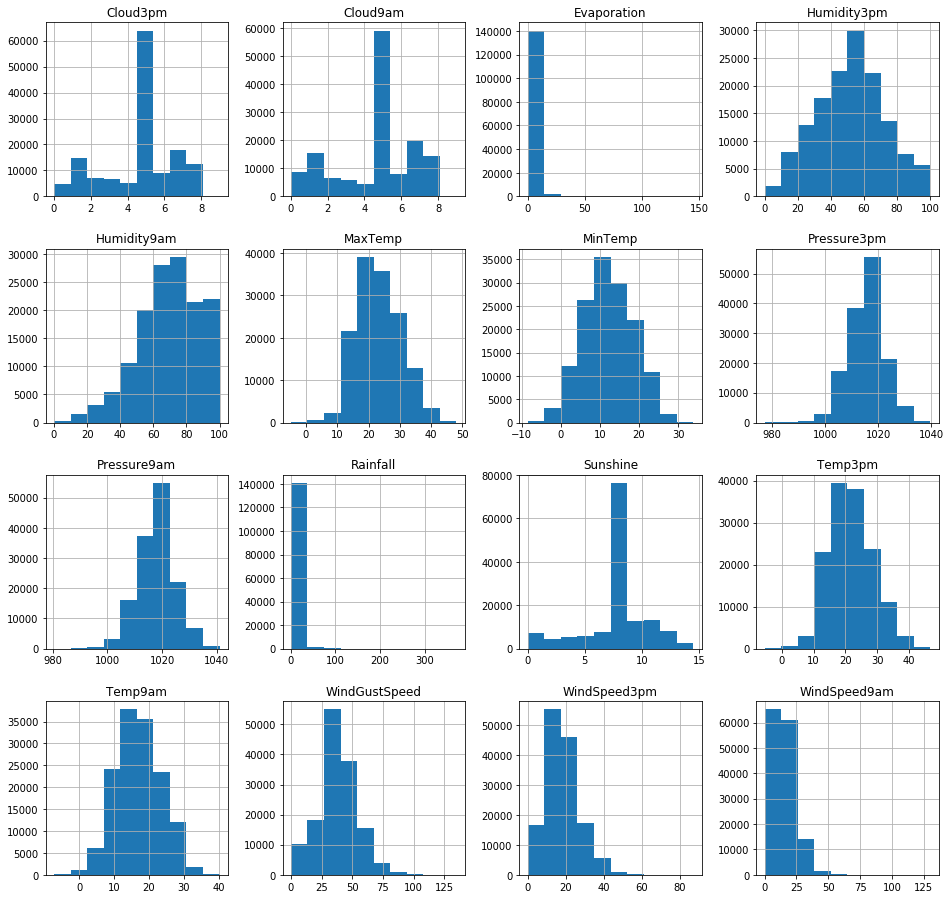

In [25]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

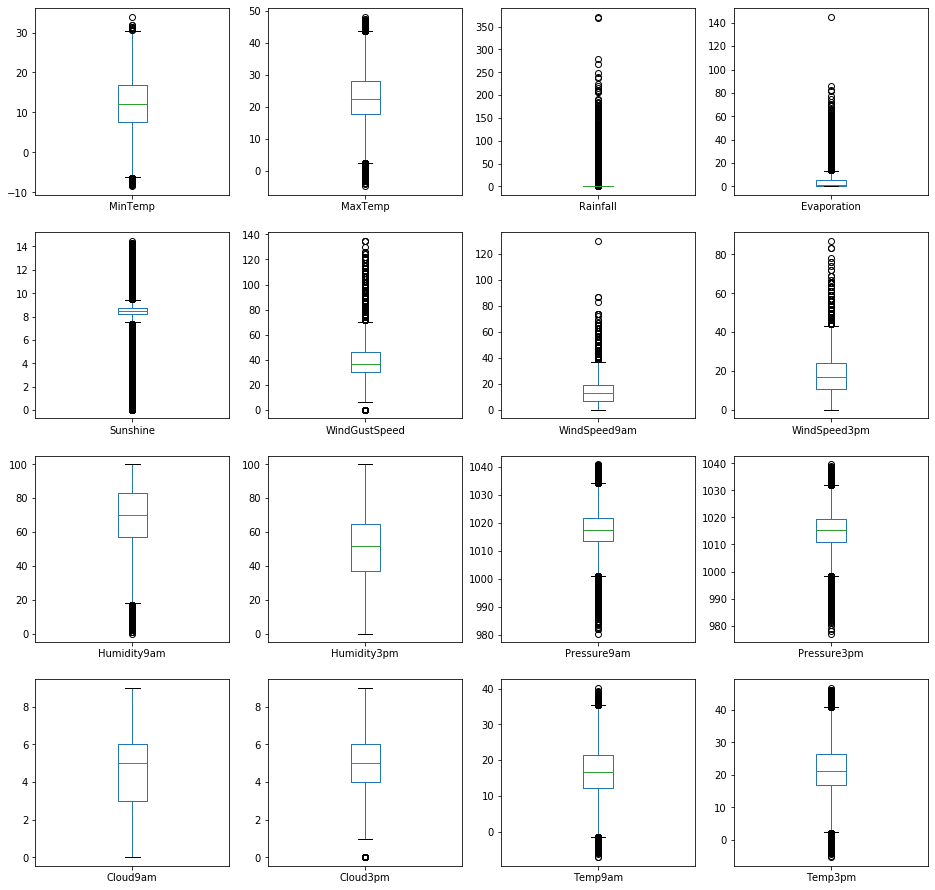

In [26]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

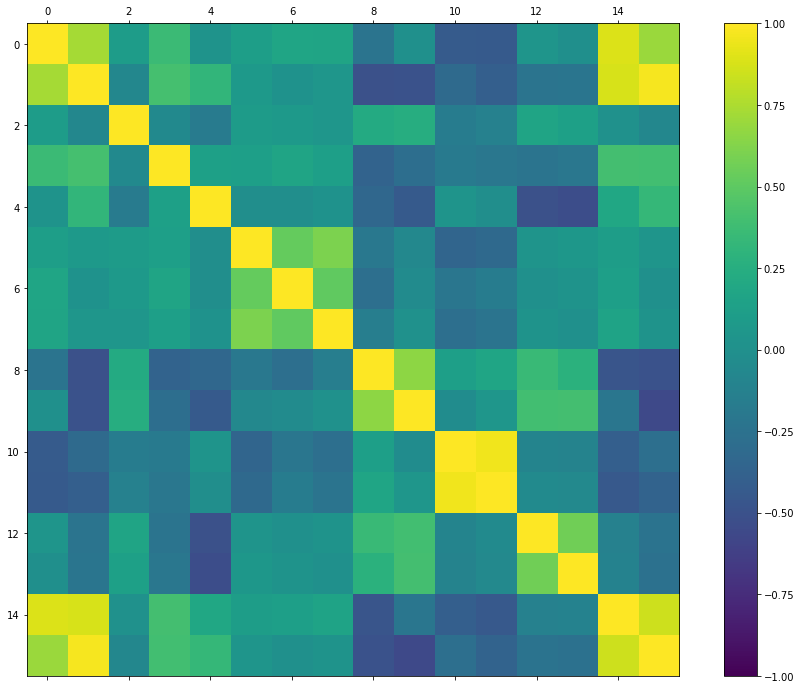

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [28]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [29]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling and Data Pre-Processing

In [30]:
# Apply feature scaling techniques
X_original['MinTemp'] = preprocessing.scale(X_original['MinTemp'])
X_original['MaxTemp'] = preprocessing.scale(X_original['MaxTemp'])
X_original['Rainfall'] = preprocessing.scale(X_original['Rainfall'])
X_original['Evaporation'] = preprocessing.scale(X_original['Evaporation'])
X_original['Sunshine'] = preprocessing.scale(X_original['Sunshine'])
X_original['WindGustSpeed'] = preprocessing.scale(X_original['WindGustSpeed'])
X_original['WindSpeed9am'] = preprocessing.scale(X_original['WindSpeed9am'])
X_original['WindSpeed3pm'] = preprocessing.scale(X_original['WindSpeed3pm'])
X_original['Humidity9am'] = preprocessing.scale(X_original['Humidity9am'])
X_original['Humidity3pm'] = preprocessing.scale(X_original['Humidity3pm'])
X_original['Pressure9am'] = preprocessing.scale(X_original['Pressure9am'])
X_original['Pressure3pm'] = preprocessing.scale(X_original['Pressure3pm'])
X_original['Cloud9am'] = preprocessing.scale(X_original['Cloud9am'])
X_original['Cloud3pm'] = preprocessing.scale(X_original['Cloud3pm'])
X_original['Temp9am'] = preprocessing.scale(X_original['Temp9am'])
X_original['Temp3pm'] = preprocessing.scale(X_original['Temp3pm'])
    
print(X_original.head(-10))

       Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
0        Albury  0.190085 -0.045764 -0.204920    -0.751043   0.16528   
1        Albury -0.749042  0.263677 -0.276125    -0.751043   0.16528   
2        Albury  0.111824  0.348070 -0.276125    -0.751043   0.16528   
3        Albury -0.467304  0.671577 -0.276125    -0.751043   0.16528   
4        Albury  0.831821  1.276393 -0.157450    -0.751043   0.16528   
...         ...       ...       ...       ...          ...       ...   
142178    Uluru -1.406431 -0.650581 -0.276125    -0.751043   0.16528   
142179    Uluru -1.531648 -0.580253 -0.276125    -0.751043   0.16528   
142180    Uluru -1.109041 -0.495860 -0.276125    -0.751043   0.16528   
142181    Uluru -1.515996 -0.284878 -0.276125    -0.751043   0.16528   
142182    Uluru -1.547300 -0.256747 -0.276125    -0.751043   0.16528   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  \
0                W       0.402991          W        WNW  

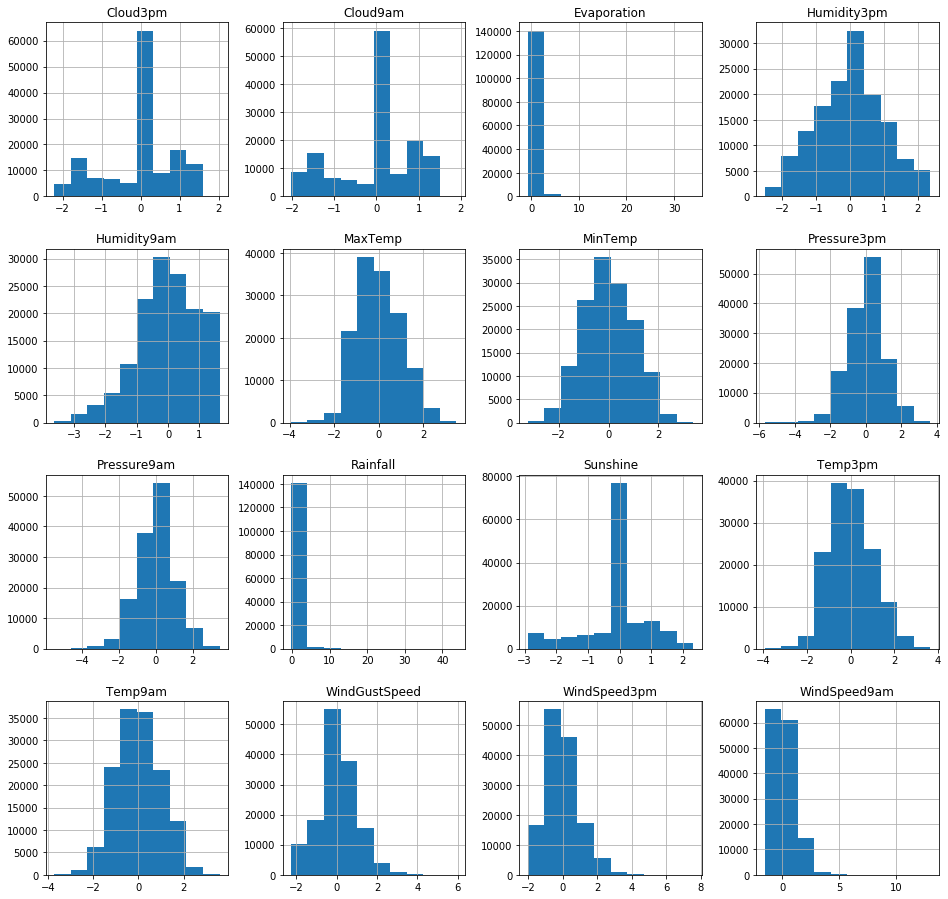

In [31]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

In [32]:
# Apply binning techniques with continuous data

# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_original['new_feature1'] = feature_binned
# X_original['new_feature1'] = X_original['new_feature1'].astype('category')

# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature2']])
# X_original['new_feature2'] = feature_binned
# X_original['new_feature2'] = X_original['new_feature2'].astype('category')

# X_original.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_original.head()

### 3.b) Apply One-Hot-Encoding to Categorical Features

In [33]:
# Perform one-hot-encoding on the categorical attributes
X_original = pd.get_dummies(X_original)
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 118 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   MinTemp                    float64
 1   MaxTemp                    float64
 2   Rainfall                   float64
 3   Evaporation                float64
 4   Sunshine                   float64
 5   WindGustSpeed              float64
 6   WindSpeed9am               float64
 7   WindSpeed3pm               float64
 8   Humidity9am                float64
 9   Humidity3pm                float64
 10  Pressure9am                float64
 11  Pressure3pm                float64
 12  Cloud9am                   float64
 13  Cloud3pm                   float64
 14  Temp9am                    float64
 15  Temp3pm                    float64
 16  Location_Adelaide          uint8  
 17  Location_Albany            uint8  
 18  Location_Albury            uint8  
 19  Location_AliceSprings      uint8  
 20  Loc

### 3.c) Training Data Balancing

In [34]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [36]:
# Split the data further into training and test datasets
if (splitDataset):
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    X_train_df, y_train_df = X_original, y_original
    X_test_df, y_test_df = X_original, y_original
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (106644, 118) y_train_df.shape: (106644,)
X_test_df.shape: (35549, 118) y_test_df.shape: (35549,)


In [37]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (106644, 118) y_train.shape: (106644,)
X_test.shape: (35549, 118) y_test.shape: (35549,)


In [38]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate one linear, two non-linear and four ensemble algorithms:

Linear Algorithm: Logistic Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Bagged CART, Random Forest, Extra Trees, and Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [39]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
# train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, tree_method='gpu_hist')))

In [40]:
# Generate model in turn
for name, model in train_models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	print('Cross Validation Results:', cv_results)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Cross Validation Results: [0.84743776 0.8542829  0.84443715 0.84687515 0.84555514]
LGR: 0.847718 (0.003445)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=888, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Model training time: 0:00:12.334651 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Cross Validation Results: [0.78962914 0.79131699 0.78423742 0.78962914 0.78629032]
CART: 0.788221 (0.002575)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=888, splitter='best')
Model training time: 0:00:21.075792 

Cross Validation Results: [0.8367012  0.83918608 0.83112195 0.83145014 0.83617779]
KNN: 0.834927 (0.003144)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=5, p=2,
                     weights='uniform')
Model training time: 0:25:36.667136 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 25.6min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Cross Validation Results: [0.84021754 0.84687515 0.83951428 0.84256177 0.84363278]
BGT: 0.842560 (0.002628)
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=2,
                  oob_score=False, random_state=888, verbose=0,
                  warm_start=False)
Model training time: 0:01:12.183915 

Cross Validation Results: [0.85320456 0.86042477 0.84968822 0.85447044 0.85291635]
RNF: 0.854141 (0.003516)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Cross Validation Results: [0.85114164 0.85789301 0.8482348  0.85057902 0.85132221]
EXT: 0.851834 (0.003224)
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                     oob_score=False, random_state=888, verbose=0,
                     warm_start=False)
Model training time: 0:01:16.291272 

Cross Validation Results: [0.8485161  0.8548924  0.844906   0.84856299 0.8471024 ]
GBM: 0.848796 (0.003326)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=No

[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  5.3min finished


### 4.b) Spot-checking baseline algorithms

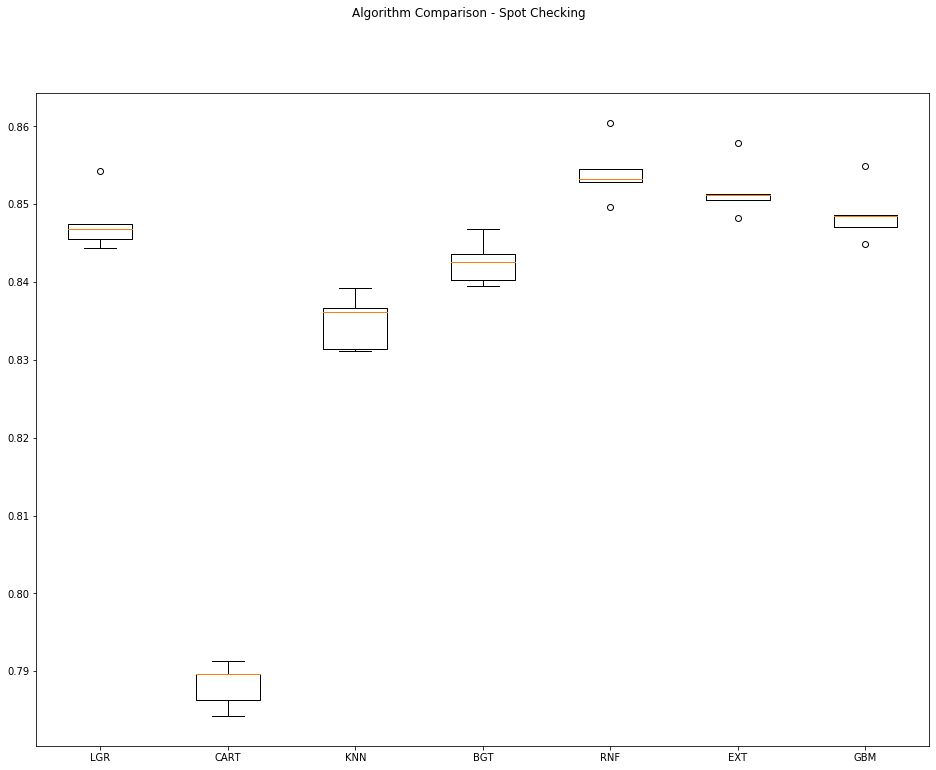

In [41]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [42]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [43]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([50, 75, 100, 125, 150]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)
print('Grid Search Results:', grid_result1)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  5.6min finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=2,
                                            oob_score=False, random_state=888,
                       

In [44]:
for key, value in grid_result1.best_params_.items():
    best_paramKey1 = key
    best_paramValue1 = value
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 150


In [45]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([50, 75, 100, 125, 150]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)
print('Grid Search Results:', grid_result2)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  6.0min finished


Grid Search Results: GridSearchCV(cv=KFold(n_splits=5, random_state=888, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=2,
                                   

In [46]:
for key, value in grid_result2.best_params_.items():
    best_paramKey2 = key
    best_paramValue2 = value
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 75


### 5.b) Compare Algorithms After Tuning

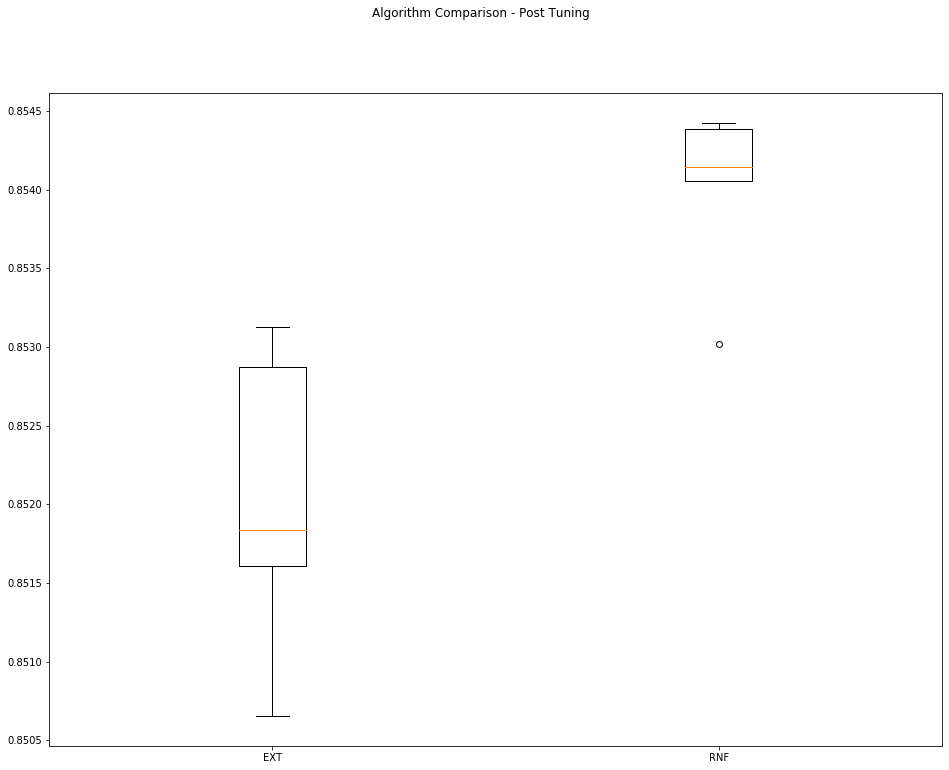

In [47]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [48]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [49]:
test_model1 = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.8550732791358406
ROC/AUC Score: 0.7243059740832201
[[26514  1066]
 [ 4086  3883]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     27580
           1       0.78      0.49      0.60      7969

    accuracy                           0.86     35549
   macro avg       0.83      0.72      0.76     35549
weighted avg       0.85      0.86      0.84     35549

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=2,
                     oob_score=False, random_state=888, verbose=0,
                     warm_start=False)


In [50]:
test_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.8552139300683563
ROC/AUC Score: 0.7309548849143584
[[26372  1208]
 [ 3939  4030]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     27580
           1       0.77      0.51      0.61      7969

    accuracy                           0.86     35549
   macro avg       0.82      0.73      0.76     35549
weighted avg       0.85      0.86      0.84     35549

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=2,
                       oob_score=False, random_state=888, verbose=0,
                       warm_start=False)


### 6.b) Create a standalone model using all available data

In [51]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [52]:
# modelName = 'FinalModel_BinaryClass.sav'
# dump(final_model, modelName)

In [53]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:49:46.956692
